# Common Libraries

In [1]:
import os
import numpy as np
import nibabel as nb
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from glob import glob
from scipy.stats import ttest_1samp
from copy import copy

import seaborn as sns
from scipy.stats import ttest_1samp
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.lines import Line2D

# Custom Libraries

In [6]:
import sys

sys.path.append("/home/seojin")
sys.path.append("/home/seojin/Seojin_commonTool/Module")
sys.path.append("/home/seojin/Seojin_commonTool/Module/Brain_Surface")

import surfAnalysisPy as surf
from surface_analysis import vol_to_surf, surface_profile, surf_paths, gaussian_weighted_smoothing, load_surfData_fromVolume
from surface_analysis import surf_paths, show_both_hemi_sampling_coverage, show_both_hemi_images, plot_virtualStrip_on3D_surf
from surface_analysis import get_bounding_box, detect_sulcus, detect_roi_names, draw_cross_section_1dPlot, show_both_hemi_stats

from sj_matplotlib import make_colorbar
from sj_math import round_down

# Params

In [7]:
surf_resolution = 32

# Nifti image paths
onMove_volume_data_dir_path = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/Group/rsa/rdm/set/WholeSet/base_seqOnly/None/pattern_separation"
onMove_volume_data_paths = sorted(glob(onMove_volume_data_dir_path + "/*crossnobis*"))

onRest_volume_data_dir_path = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/Group/rsa/rdm/set/WholeSet/base_seq_restOnly/None/pattern_separation"
onRest_volume_data_paths = sorted(glob(onRest_volume_data_dir_path + "/*crossnobis*"))

# ROI
atlas = "Brodmann"

# For cross-section analysis (virtual strip)
L_from_point = np.array([-24, 111])  
L_to_point = np.array([81, 47])    

R_from_point = np.array([23, 80])
R_to_point = np.array([-75, 22]) 
    
width = 20
cross_section_n_sampling = 30

# Paths
save_dir_path = "/mnt/ext1/seojin/temp"

# Constants

In [8]:
l_surf_info = surf_paths("L")
r_surf_info = surf_paths("R")

# Functions

In [9]:
def do_smoothing(volume_data_paths, hemisphere, sigma = 2.0):
    surf_data = load_surfData_fromVolume(volume_data_paths, hemisphere = hemisphere)

    template_path = surf_paths(hemisphere)[f"{hemisphere}_template_surface_path"]
    temploate_surface_data = nb.load(template_path)
    vertex_locs = temploate_surface_data.darrays[0].data[:, :2]

    mean_data = np.mean(surf_data, axis = 1)
    smoothed_data = gaussian_weighted_smoothing(coords = vertex_locs, 
                                                values = mean_data, 
                                                sigma = sigma)

    return smoothed_data

# Volume to Surface

In [10]:
# Load surf datas
l_surf_data_onMove = load_surfData_fromVolume(onMove_volume_data_paths, hemisphere = "L")
r_surf_data_onMove = load_surfData_fromVolume(onMove_volume_data_paths, hemisphere = "R")

l_surf_data_onRest = load_surfData_fromVolume(onRest_volume_data_paths, hemisphere = "L")
r_surf_data_onRest = load_surfData_fromVolume(onRest_volume_data_paths, hemisphere = "R")

# Smoothing
l_smoothed_data_onMove = do_smoothing(onMove_volume_data_paths, hemisphere = "L")
r_smoothed_data_onMove = do_smoothing(onMove_volume_data_paths, hemisphere = "R")

# Cross section analysis

In [12]:
l_cross_section_result_info_onMove = surface_profile(template_surface_path = l_surf_info["L_template_surface_path"],
                                                           surface_data = l_surf_data_onMove,
                                                           from_point = L_from_point,
                                                           to_point = L_to_point,
                                                           width = width,
                                                           n_sampling = cross_section_n_sampling)

r_cross_section_result_info_onMove = surface_profile(template_surface_path = r_surf_info["R_template_surface_path"],
                                                           surface_data = r_surf_data_onMove,
                                                           from_point = R_from_point,
                                                           to_point = R_to_point,
                                                           width = width,
                                                           n_sampling = cross_section_n_sampling)

l_cross_section_result_info_onRest = surface_profile(template_surface_path = l_surf_info["L_template_surface_path"],
                                                           surface_data = l_surf_data_onRest,
                                                           from_point = L_from_point,
                                                           to_point = L_to_point,
                                                           width = width,
                                                           n_sampling = cross_section_n_sampling)

r_cross_section_result_info_onRest = surface_profile(template_surface_path = r_surf_info["R_template_surface_path"],
                                                           surface_data = r_surf_data_onRest,
                                                           from_point = R_from_point,
                                                           to_point = R_to_point,
                                                           width = width,
                                                           n_sampling = cross_section_n_sampling)

# Virtual strip
l_virtual_stip_mask = l_cross_section_result_info_onMove["virtual_stip_mask"]
r_virtual_stip_mask = r_cross_section_result_info_onMove["virtual_stip_mask"]

# Bounding box

In [13]:
left_bounding_box = get_bounding_box("L", l_virtual_stip_mask)
right_bounding_box = get_bounding_box("R", r_virtual_stip_mask)

# Cross-section analysis coverages

save: /mnt/ext1/seojin/temp/L_hemi_coverage.png
save: /mnt/ext1/seojin/temp/R_hemi_coverage.png
save: /mnt/ext1/seojin/temp/both_hemi_coverage.png


<Figure size 640x480 with 0 Axes>

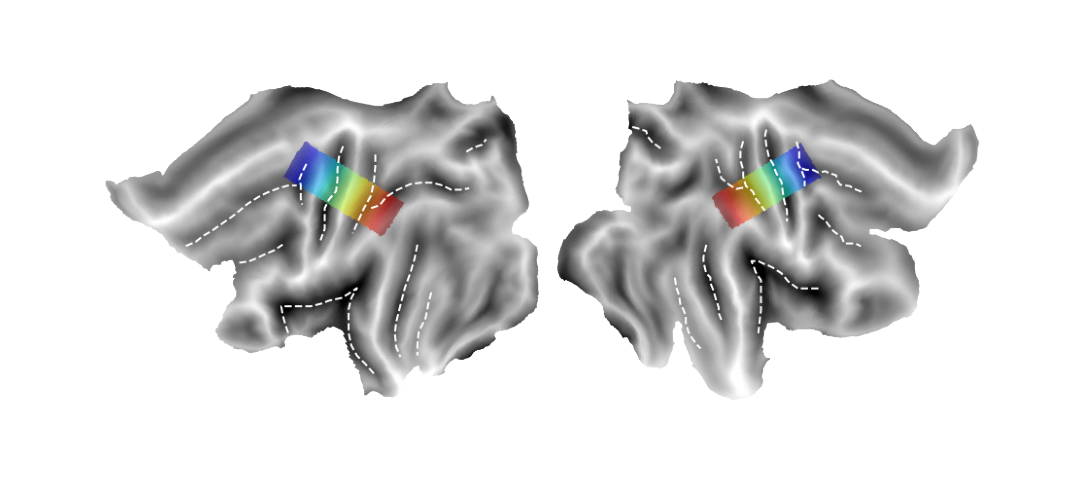

In [14]:
show_both_hemi_sampling_coverage(l_sampling_coverage = l_cross_section_result_info_onMove["sampling_coverages"],
                                 r_sampling_coverage = r_cross_section_result_info_onMove["sampling_coverages"],
                                 save_dir_path = save_dir_path,
                                 surf_resolution = surf_resolution)

# Visualization threshold

In [15]:
l_t_stat = ttest_1samp(l_surf_data_onMove, axis = 1, popmean = 0)
r_t_stat = ttest_1samp(r_surf_data_onMove, axis = 1, popmean = 0)

# threshold
threshold = np.mean(np.r_[l_smoothed_data_onMove[l_t_stat.pvalue < 0.05], r_smoothed_data_onMove[r_t_stat.pvalue < 0.05]])
threshold = round_down(threshold, 4)

# max scale
max_scale = np.mean(np.r_[l_smoothed_data_onMove[l_t_stat.pvalue < 0.00001], r_smoothed_data_onMove[r_t_stat.pvalue < 0.00001]])
max_scale = round_down(max_scale, 4)

# Show brain figures

save: /mnt/ext1/seojin/temp/L_hemi_stat.png
save: /mnt/ext1/seojin/temp/R_hemi_stat.png
save: /mnt/ext1/seojin/temp/colorbar.png
save: /mnt/ext1/seojin/temp/Both_hemi_stat.png


<Figure size 640x480 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

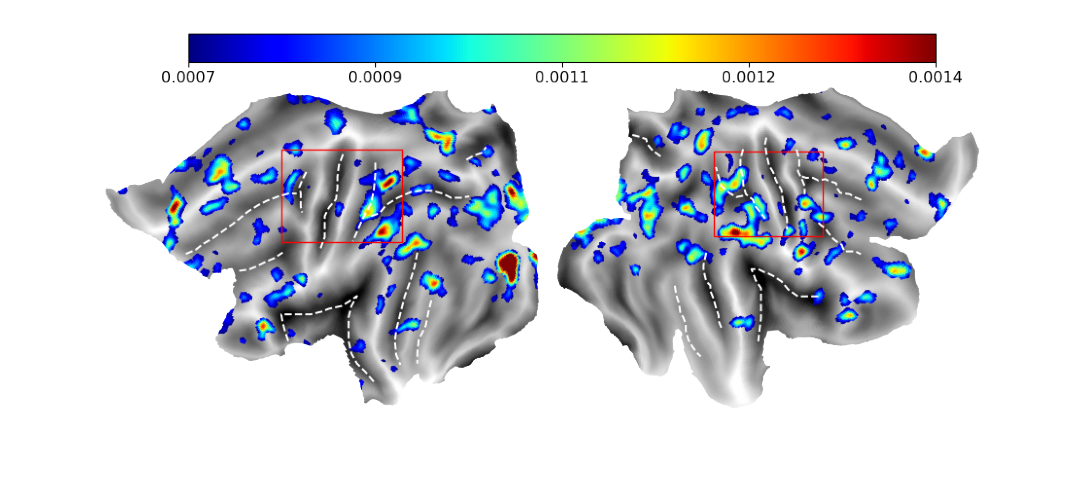

In [16]:
fig, axis = show_both_hemi_stats(l_stat = l_smoothed_data_onMove,
                                 r_stat = r_smoothed_data_onMove,
                                 threshold = threshold,
                                 cscale = (threshold, max_scale),
                                 save_dir_path = save_dir_path,
                                 left_bounding_box = left_bounding_box,
                                 right_bounding_box = right_bounding_box,
                                 is_focusing_bounding_box = False,
                                 zoom = 0.7)

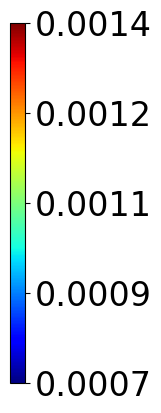

In [19]:
colorbar_path = "/mnt/ext1/seojin/temp/colorbar.png"
fig, axis, ticks = make_colorbar(threshold, max_scale, figsize = (1, 4), orientation = "vertical", fontsize = 24)
fig.savefig(colorbar_path, dpi = 300, transparent = True, bbox_inches = "tight")

save: /mnt/ext1/seojin/temp/L_hemi_stat.png
save: /mnt/ext1/seojin/temp/R_hemi_stat.png
save: /mnt/ext1/seojin/temp/colorbar.png
save: /mnt/ext1/seojin/temp/Both_hemi_stat.png


<Figure size 640x480 with 0 Axes>

<Figure size 1000x100 with 0 Axes>

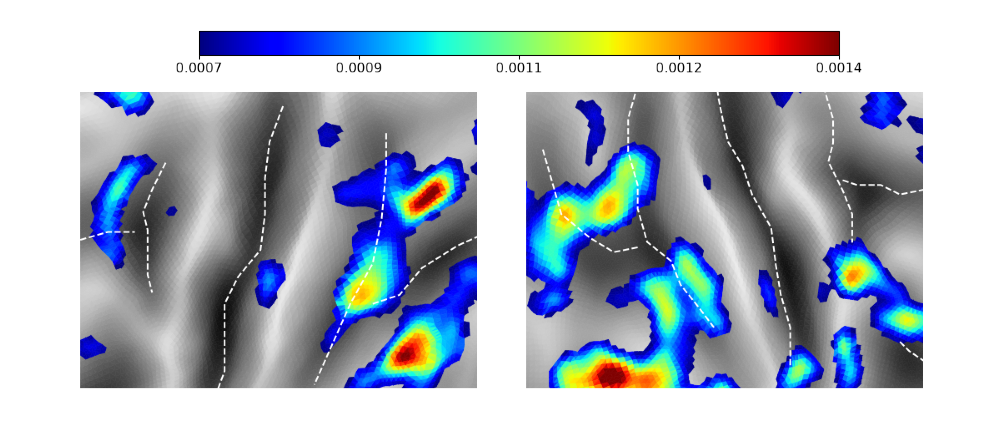

In [20]:
fig, axis = show_both_hemi_stats(l_stat = l_smoothed_data_onMove,
                                 r_stat = r_smoothed_data_onMove,
                                 threshold = threshold,
                                 cscale = (threshold, max_scale),
                                 save_dir_path = save_dir_path,
                                 left_bounding_box = left_bounding_box,
                                 right_bounding_box = right_bounding_box,
                                 is_focusing_bounding_box = True,
                                 zoom = 0.6)

# Surf ROI

save: /mnt/ext1/seojin/temp/L_virtual_strip.png


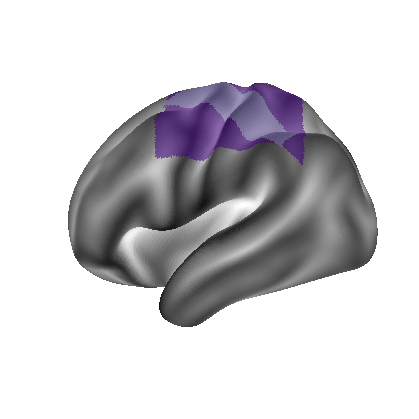

In [14]:
l_strip_fig = plot_virtualStrip_on3D_surf(l_cross_section_result_info_onMove["virtual_stip_mask"], 
                                          hemisphere = "L",
                                          save_dir_path = save_dir_path,
                                          view = (0, 180),
                                          vmax = 1,
                                          darkness = 1)

save: /mnt/ext1/seojin/temp/R_virtual_strip.png


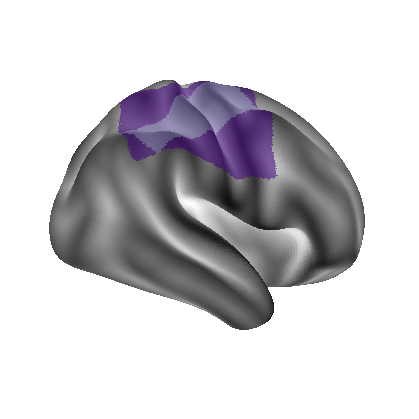

In [15]:
r_strip_fig = plot_virtualStrip_on3D_surf(r_cross_section_result_info_onMove["virtual_stip_mask"], 
                                          hemisphere = "R",
                                          save_dir_path = save_dir_path,
                                          view = (0, 0),
                                          vmax = 1,
                                          darkness = 1)

# 1D-plot for sampling areas

## Detect names

In [16]:
def get_rois(sampling_coverages, hemisphere):
    rois = detect_roi_names(sampling_coverages, hemisphere)
    rois = [roi.replace("|", "") for roi in rois]
    rois = np.array([roi.replace(f"{hemisphere}_", "") for roi in rois])
    rois[np.where(rois == "2")[0]] = "1+2+3"
    rois = np.where(rois == "1+2+3", "3+1+2", rois)
    rois = np.array([roi.replace("+", ", ") for roi in rois])

    return rois

In [17]:
# Suclus names
l_sulcus_names = detect_sulcus("L", l_cross_section_result_info_onMove["sampling_coverages"], False)
r_sulcus_names = detect_sulcus("R", r_cross_section_result_info_onMove["sampling_coverages"], False)[::-1]
r_sulcus_names[-1] = ""

# region names
l_roi_names = get_rois(l_cross_section_result_info_onMove["sampling_coverages"], hemisphere = "L")
r_roi_names = get_rois(r_cross_section_result_info_onMove["sampling_coverages"], hemisphere = "R")[::-1]

## Stats

In [18]:
p_threshold = 0.05

l_sampling_datas_onMove = np.expand_dims(l_cross_section_result_info_onMove["sampling_datas"], axis = 0)
l_sampling_datas_onRest = np.expand_dims(l_cross_section_result_info_onRest["sampling_datas"], axis = 0)
l_sampling_datas = np.concatenate([l_sampling_datas_onMove, l_sampling_datas_onRest])

r_sampling_datas_onMove = np.expand_dims(r_cross_section_result_info_onMove["sampling_datas"][::-1], axis = 0)
r_sampling_datas_onRest = np.expand_dims(r_cross_section_result_info_onRest["sampling_datas"][::-1], axis = 0)
r_sampling_datas = np.concatenate([r_sampling_datas_onMove, r_sampling_datas_onRest])

# Plotting

In [317]:
def draw_both_hemi_cross_section_1dPlot(cmap = "tab10"):
    fig, axes = plt.subplots(1, 2, sharey=True)
    fig.set_figwidth(15)
    
    draw_cross_section_1dPlot(ax = axes[0], 
                              sampling_datas = l_sampling_datas, 
                              sulcus_names = l_sulcus_names, 
                              roi_names = l_roi_names,
                              p_threshold = 0.05,
                              y_range = (0, 0.0014),
                              tick_size = 24,
                              sulcus_text_size = 16,
                              cmap = cmap)

    # xmin, xmax = axis[0].get_xlim()
    axes[0].hlines(y=0., xmin=0, xmax=30, color='k', linestyle='--')
    
    draw_cross_section_1dPlot(ax = axes[1], 
                              sampling_datas = r_sampling_datas, 
                              sulcus_names = r_sulcus_names, 
                              roi_names = r_roi_names,
                              p_threshold = 0.05,
                              y_range = (0, 0.0014),
                              tick_size = 24,
                              sulcus_text_size = 16,
                              cmap = cmap)
    
    axes[0].set_xlabel("")
    axes[1].set_xlabel("")
    axes[0].set_ylabel("")
    axes[1].set_ylabel("")
    axes[1].get_yaxis().set_visible(False)
    axes[1].spines['left'].set_visible(False)
    axes[1].hlines(y=0., xmin=0, xmax=30, color='k', linestyle='--')
    # fig.supxlabel("Brodmann area", fontsize = 18, fontweight = "bold", y = -0.01)
    fig.subplots_adjust(wspace = 0.1)

    return fig, axes

0 [ 1  2  3  7  8 15 16 21 22 23 24 26 27 28 29]
1 []
0 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 15 16 27 28 29]
1 []
save: /mnt/ext1/seojin/temp/both_hemi_1dplot.png


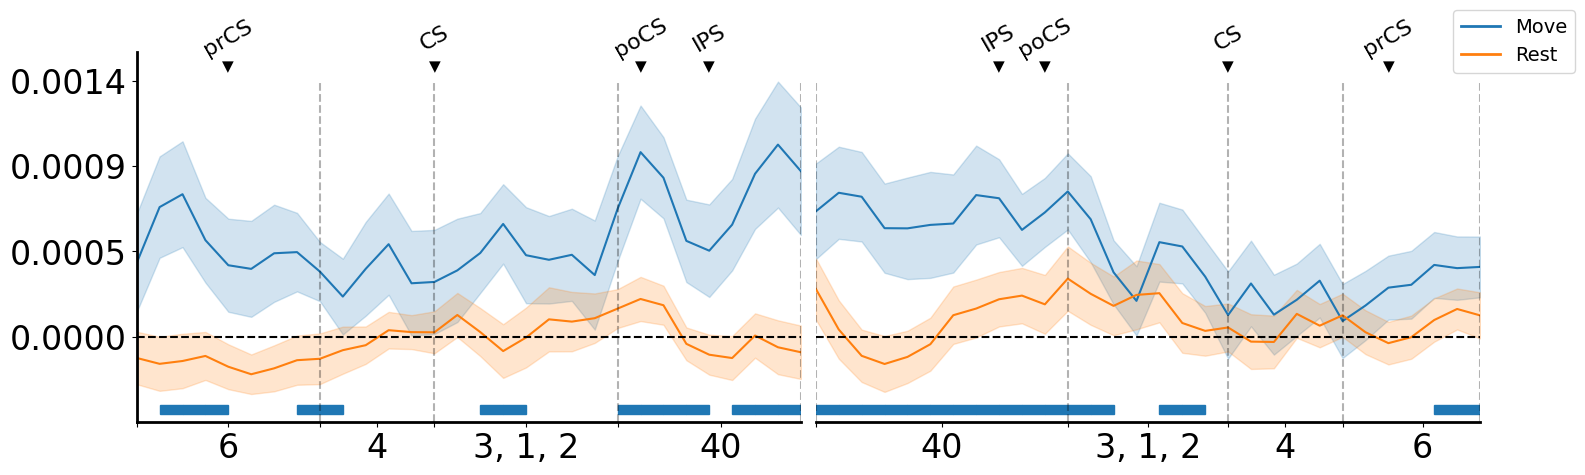

In [318]:
fig, axis = draw_both_hemi_cross_section_1dPlot(cmap = "tab10")

cmap = plt.get_cmap("tab10", 10)
custom_lines = [Line2D([0], [0], color = cmap.colors[0], lw = 2, label = "Move"),
                Line2D([0], [0], color = cmap.colors[1], lw = 2, label = "Rest")]
    
# Add the legend to the figure
fig.legend(handles = custom_lines, 
           loc = "upper right", 
           ncol = 1, 
           bbox_to_anchor=(1.06, 1),
           fontsize = 14)

fig.tight_layout()
file_path = os.path.join(save_dir_path, "both_hemi_1dplot.png")
fig.savefig(file_path, transparent = True, bbox_inches = "tight")
print(f"save: {file_path}")